In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Input
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

In [7]:
testing_path='BDSL_Video_Numpy'
sequence_length = 60

In [8]:
actions = [d for d in os.listdir('BDSL_Video_Numpy') if os.path.isdir(os.path.join('BDSL_Video_Numpy', d))]

In [9]:


label_map = {label:num for num, label in enumerate(actions)}
label_map
sequences, labels = [], []
for action in actions:
    sequence_folders = os.listdir(os.path.join(testing_path, action))

    for sequence_folder in sequence_folders:
        window = []
        skip_sequence = False

        for frame_num in range(sequence_length):
            frame_path = os.path.join(testing_path, action, sequence_folder, f"frame_{frame_num:03}.npy")
            
            if not os.path.exists(frame_path):
                print(f"Missing file: {frame_path} — skipping this sequence.")
                skip_sequence = True
                break

            window.append(np.load(frame_path))
        
        if skip_sequence:
            continue
        
        sequences.append(window)
        labels.append(action)

np.array(sequences).shape
np.array(labels).shape

(8648,)

In [10]:
# Convert to numpy arrays
X = np.array(sequences)
y = np.array(labels)

In [11]:
# Label encode string labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [12]:
# Split BEFORE scaling
X_train, X_test, y_train_int, y_test_int = train_test_split(
    X, y_encoded, stratify=y_encoded, test_size=0.2, random_state=42
)

In [13]:
# Create empty arrays for scaled training and test data
X_train_scaled = np.zeros_like(X_train)
X_test_scaled = np.zeros_like(X_test)

In [14]:
scaler = StandardScaler()

# Scale each sequence independently
for i in range(X_train.shape[0]):
    X_train_scaled[i] = scaler.fit_transform(X_train[i])

for i in range(X_test.shape[0]):
    X_test_scaled[i] = scaler.fit_transform(X_test[i])

In [15]:
# One-hot encode integer labels
y_train_cat = to_categorical(y_train_int)
y_test_cat = to_categorical(y_test_int)

In [16]:
# Optional: check class label mapping
print("Class labels:", label_encoder.classes_)

Class labels: ['Good to See You' 'Leave' 'Please' 'What Time is It' 'Where Do You Live'
 'abar dekha hbe' 'ami dukkhito' 'ami valo achi'
 'apnake amar valo legeche' 'apnake kivabe sahajjo korte pari'
 'apnar nam ki' 'apni kemon achen' 'apni ki kaj koren' 'apni valo thakben'
 'asha' 'baba' 'boi' 'bon' 'college' 'computer' 'dekha' 'dhonnobad' 'fan'
 'ghumano' 'hata' 'hello' 'internet' 'kaj' 'kolom' 'light' 'ma' 'mobile'
 'office' 'shami' 'shuvo jonmodin' 'shuvo oporanho' 'shuvo ratri'
 'shuvo sokal' 'stri' 'vai']


In [17]:
# Build the improved model
model = Sequential()
model.add(Input(shape=(X.shape[1], X.shape[2])))
# First LSTM layer (Bidirectional for better temporal understanding)
model.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.1)))
model.add(BatchNormalization()) 
model.add(Dropout(0.3))  # general dropout

# Second LSTM layer
model.add(Bidirectional(LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.1)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Dense layer with regularization
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Output layer
model.add(Dense(len(actions), activation='softmax'))



In [18]:
# Compile with a custom learning rate
optimizer = Adam(learning_rate=0.0005)  # slower LR for better convergence
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 60, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 60, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │         2,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 209,768 (819.41 KB)

 Trainable params: 209,128 (816.91 KB)

 Non-trainable params: 640 (2.50 KB)

In [ ]:
#LSTM
"""# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
checkpoint = ModelCheckpoint("npy_array_model.keras", monitor='val_accuracy', save_best_only=True)"""



"""X_scaled = np.zeros_like(X)
for i in range(X.shape[0]):
    X_scaled[i] = scaler.fit_transform(X[i])
"""
#for later


"""# Build the model

model = Sequential()
model.add(Input(shape=(X.shape[1], X.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))  # Dropout to reduce overfitting
model.add(Dense(32, activation='relu'))
model.add(Dense(len(actions), activation='softmax'))


model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])



"""
"""# Train
history = model.fit(
    X_train_scaled, y_train_cat,
    epochs=100,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint],
    batch_size=32
)"""

'# Train\nhistory = model.fit(\n    X_train_scaled, y_train_cat,\n    epochs=100,\n    validation_split=0.2,\n    callbacks=[early_stopping, checkpoint],\n    batch_size=32\n)'

In [19]:
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

checkpoint = ModelCheckpoint(
    'Final_Bi_LSTM.keras', 
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [20]:
# Train the model
history = model.fit(
    X_train_scaled, y_train_cat,
    epochs=200,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint],
    batch_size=64,  # try 64 if memory allows
    verbose=1
)



Epoch 1/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.0398 - loss: 4.2765
Epoch 1: val_accuracy improved from -inf to 0.16257, saving model to Final_Bi_LSTM.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 49s 327ms/step - accuracy: 0.0400 - loss: 4.2744 - val_accuracy: 0.1626 - val_loss: 3.4491
Epoch 2/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.0956 - loss: 3.5948
Epoch 2: val_accuracy improved from 0.16257 to 0.25217, saving model to Final_Bi_LSTM.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 29s 335ms/step - accuracy: 0.0958 - loss: 3.5935 - val_accuracy: 0.2522 - val_loss: 2.9258
Epoch 3/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.1686 - loss: 3.1742
Epoch 3: val_accuracy improved from 0.25217 to 0.33092, saving model to Final_Bi_LSTM.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 32s 367ms/step - accuracy: 0.1688 - loss: 3.1734 - val_accuracy: 0.3309 - val_loss: 2.5124
Epoch 4/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.2190 - loss: 2.8698
Epoch 4: val_accuracy imp

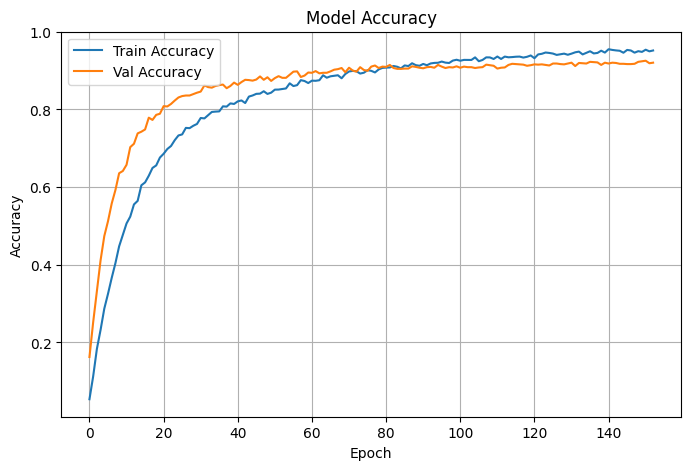

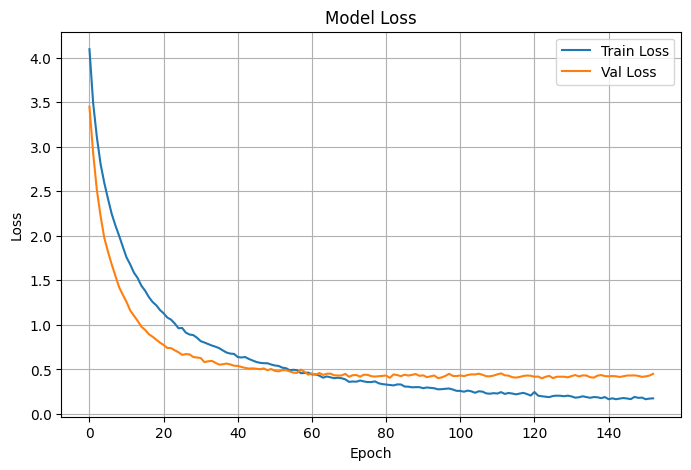

In [21]:


# -------------------------------
# 1. Plot Training History
# -------------------------------

# Plot Accuracy separately
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss separately
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()








In [22]:
# -------------------------------
# 2. Predictions & Evaluation
# -------------------------------

# Predict
y_pred_probs = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Accuracy, Precision, Recall, F1
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"\n🔍 Evaluation Metrics:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")


55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step

🔍 Evaluation Metrics:
Accuracy:  0.9185
Precision: 0.9204
Recall:    0.9185
F1 Score:  0.9184


In [23]:
# -------------------------------
# 3. Classification Report
# -------------------------------
print("\n📋 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))


📋 Classification Report:

                                  precision    recall  f1-score   support

                 Good to See You       0.95      0.87      0.91        47
                           Leave       0.87      0.95      0.91        43
                          Please       0.88      0.95      0.91        44
                 What Time is It       0.87      0.85      0.86        39
               Where Do You Live       0.96      0.94      0.95        49
                  abar dekha hbe       0.92      0.98      0.95        46
                    ami dukkhito       0.97      0.86      0.92        44
                   ami valo achi       0.95      0.98      0.96        42
        apnake amar valo legeche       0.98      0.93      0.95        45
apnake kivabe sahajjo korte pari       0.95      0.98      0.97        43
                    apnar nam ki       1.00      1.00      1.00        42
                apni kemon achen       0.96      0.96      0.96        45
          

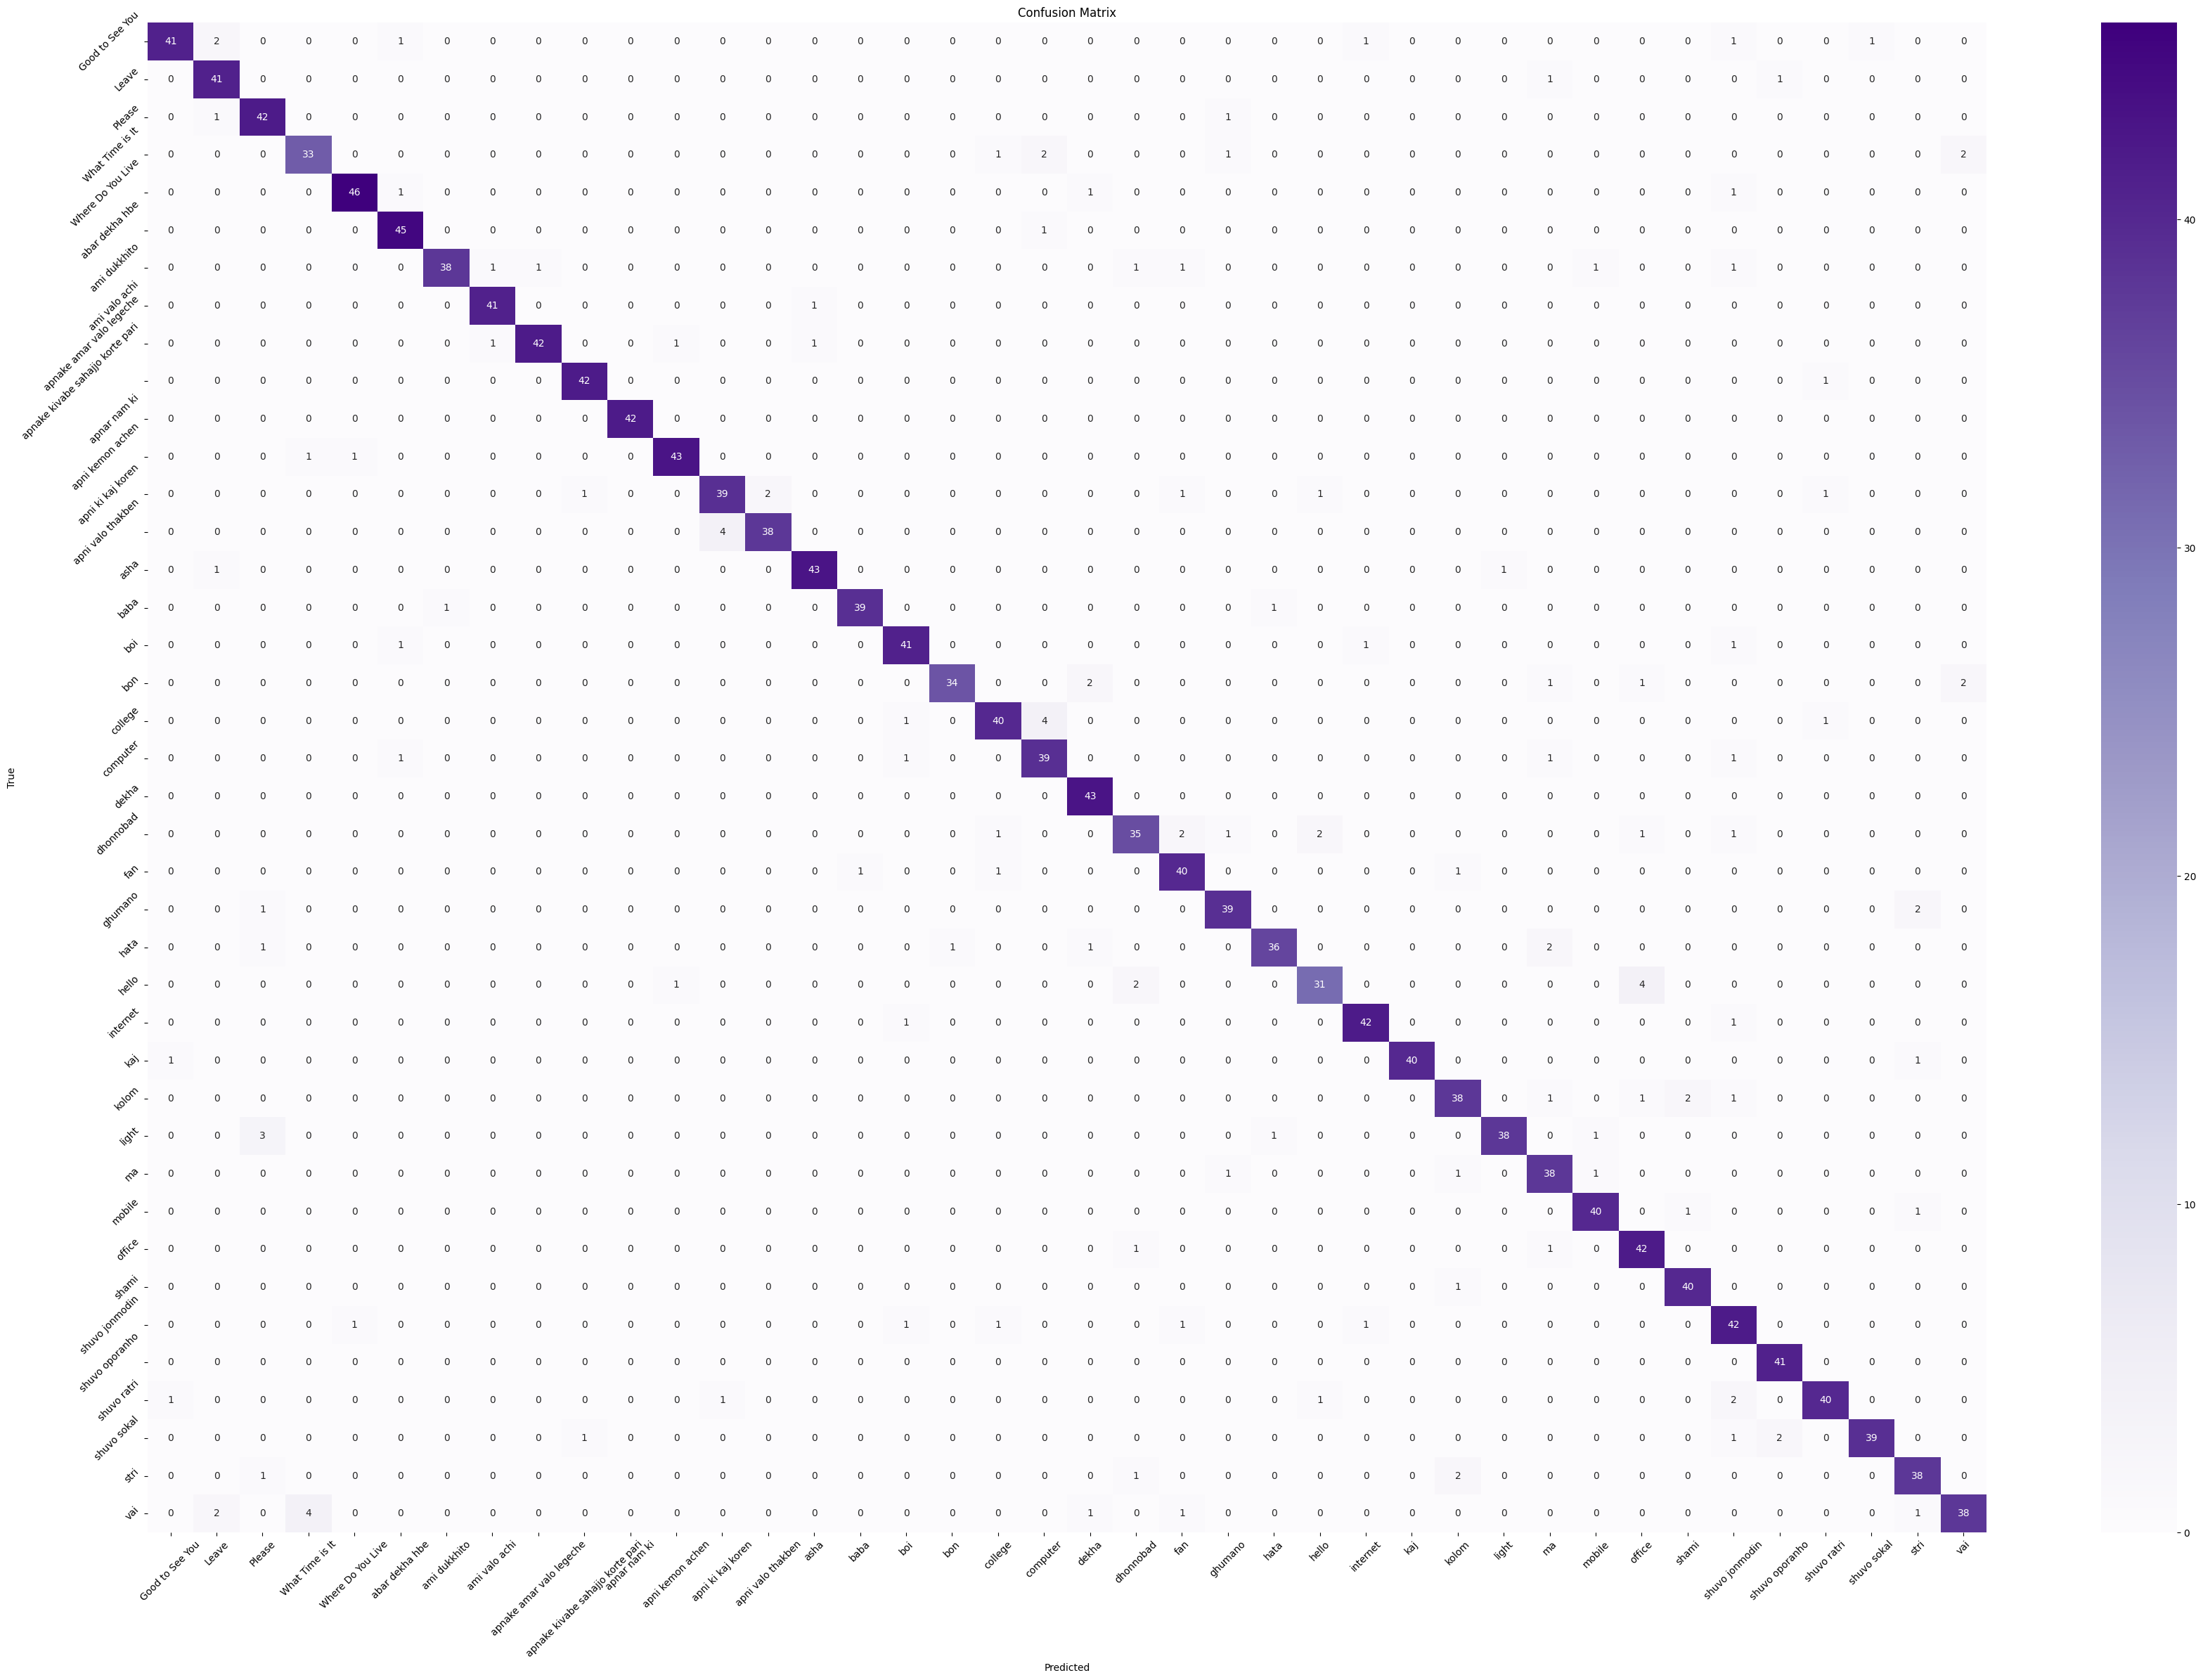

In [24]:
# -------------------------------
# 4. Confusion Matrix
# -------------------------------
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(35, 24))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

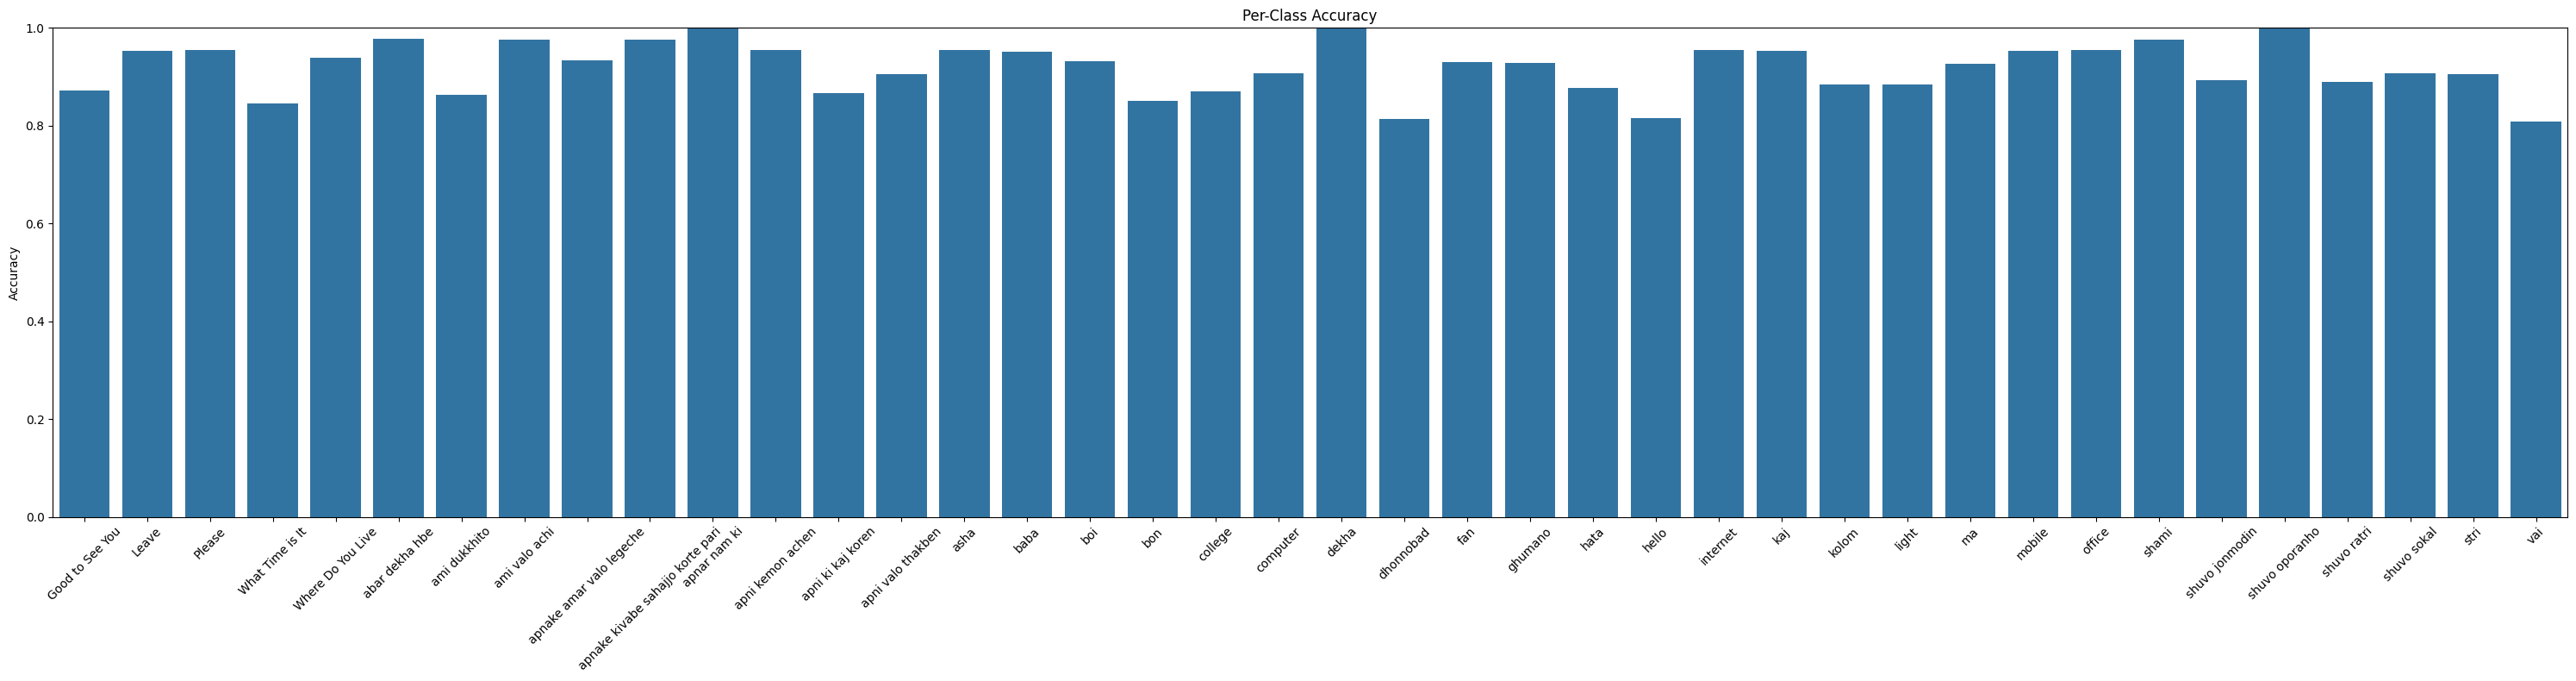

In [25]:
# Per-class accuracy
per_class_acc = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
plt.figure(figsize=(30, 8))
sns.barplot(x=label_encoder.classes_, y=per_class_acc)
plt.title("Per-Class Accuracy")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()


In [2]:
import numpy as np

# Load the array from the .npy file
arr = np.load("frame_000.npy")

# Get number of elements
print("Number of elements in the array:", arr.size)


Number of elements in the array: 128
